## Example Mediapipe dan buat fungsi

In [55]:
import cv2
import mediapipe as mp
import os
CWD = os.getcwd()
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

def getHandLandmarks(image):
    with mp_hands.Hands(
        static_image_mode=True,
        model_complexity=1,
        min_detection_confidence=0.1) as hands:

        # Read an image, flip it around y-axis for correct handedness output (see
        # above).
        image = cv2.flip(image, 1)
        # Convert the BGR image to RGB before processing.
        results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Print handedness and draw hand landmarks on the image.
        # print('Handedness:', results.multi_handedness)
        if not results.multi_hand_landmarks:
            return None
        image_height, image_width, _ = image.shape
        annotated_image = image.copy()
        detected_hands = {}
        # print('num of detected hands : ',(len(results.multi_hand_landmarks)))
        for idx,hand_landmarks in enumerate(results.multi_hand_landmarks):
            detected_hands[results.multi_handedness[idx].classification[0].label] = hand_landmarks.landmark
            mp_drawing.draw_landmarks(
                annotated_image,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style())
            # cv2.imwrite('annotated_image.png', cv2.flip(annotated_image, 1))
        
        #     # Draw hand world landmarks.
        # if not results.multi_hand_world_landmarks:
        #     return None
        # for hand_world_landmarks in results.multi_hand_world_landmarks:
        #     mp_drawing.plot_landmarks(
        #     hand_world_landmarks, mp_hands.HAND_CONNECTIONS, azimuth=5)
        return detected_hands

Handedness: [classification {
  index: 1
  score: 0.9983005523681641
  label: "Right"
}
, classification {
  index: 0
  score: 0.9911358952522278
  label: "Left"
}
]
num of detected hands :  2


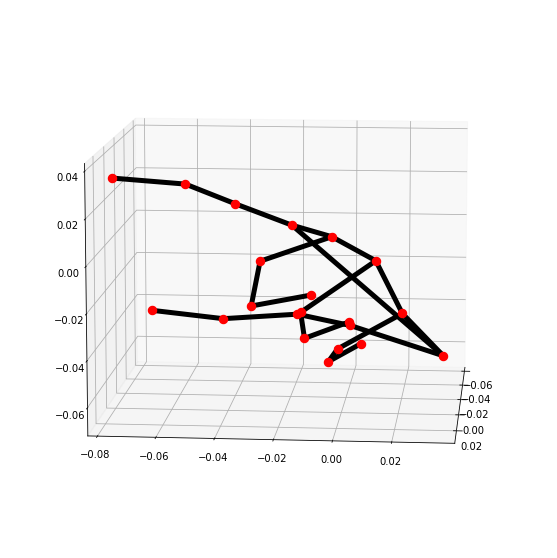

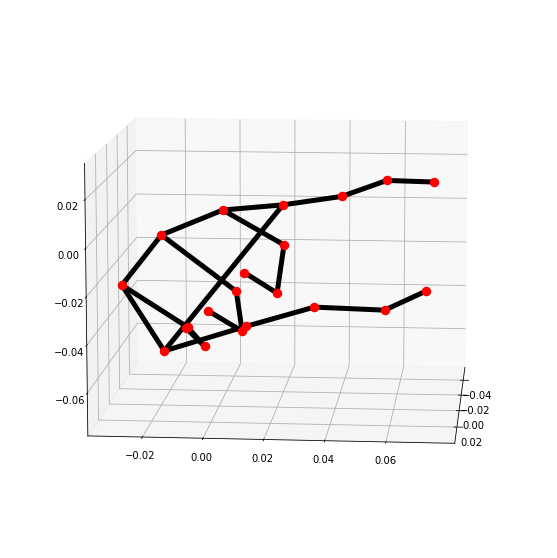

In [44]:
img = cv2.imread('Dataset/A/body dot (2).jpg')
sample = getHandLandmarks(img)

## dictionary dengan isi keys Left dan Right jika 2 tangan

In [61]:
sample.keys()

dict_keys(['Right', 'Left'])

## Annotasi Dataset

- annotasi agak manual karena dari mediapipe ternyata kadang ga detect kedua tangannya meskipun ada jadi dihapus yang salah

In [122]:
letter_hand_count = {
    'A': 2,
    'B': 2,
    'C': 1,
    'D': 2,
    'E': 1,
    'F': 2,
    'G': 2,
    'H': 2,
    'I': 1,
    'J': 1,
    'K': 2,
    'L': 1,
    'M': 2,
    'N': 2,
    'O': 1,
    'P': 2,
    'Q': 2,
    'R': 1,
    'S': 2,
    'T': 2,
    'U': 1,
    'V': 1,
    'W': 2,
    'X': 2,
    'Y': 2,
    'Z': 1,
}

In [144]:
import json

DATASET_IMG_DIR = 'Dataset'

for letter,supposed_hand_count in letter_hand_count.items():
    # letter : 'A' : huruf
    # supposed_hand_count : 2 : contoh huruf A seharusnya ada 2 tangan


    # check if dataset annotation exists
    if not os.path.exists(os.path.join(CWD, 'Dataset.json')):
        results = {}
        print('Dataset not found, creating new dataset')
        with open('Dataset.json', 'w') as f:
            json.dump(results, f)

    # load dataset
    with open('Dataset.json', 'r') as f:
        results = json.load(f)

    ###
    # results will contain list of dictionary ex:
    # result['A'] = {'Left': [], 'Right': []}

    results[letter] = {'Left': [], 'Right': []}
    for filename in os.listdir(os.path.join(CWD, DATASET_IMG_DIR, letter)):
        img = cv2.imread(os.path.join(CWD, DATASET_IMG_DIR, letter, filename))
        sample = getHandLandmarks(img)
        
        if sample is None:
            print(f'No hand detected in {filename}')
            continue

        if len(sample.keys()) != supposed_hand_count:
            print('Different Hand Counts: on', filename,' hence skipping')
            continue

        ## clean #RepeatedCompositeContainer karena tidak bisa disimpan di json
        for hand in sample.keys(): # Left, Right
            xyz = []
            for landmark in sample[hand]: # all 21 landmark points converted to set x,y,z
                xyz.append((landmark.x, landmark.y, landmark.z))
            sample[hand] = xyz

        ## make single hand double
        if supposed_hand_count == 1:
            if 'Left' in sample.keys():
                sample['Right'] = [[0,0,0] for _ in range(21)]
            else:
                sample['Left'] = [[0,0,0] for _ in range(21)]
        
        results[letter]['Left'].append(sample['Left'])
        results[letter]['Right'].append(sample['Right'])

    with open('Dataset.json', 'w') as f:
        json.dump(results, f)

Dataset not found, creating new dataset
Different Hand Counts: on body dot (1).jpg  hence skipping
Different Hand Counts: on body dot (3).jpg  hence skipping
Different Hand Counts: on body dot (4).jpg  hence skipping
Different Hand Counts: on body dot (1).jpg  hence skipping
Different Hand Counts: on body dot (2).jpg  hence skipping
No hand detected in body dot (3).jpg
Different Hand Counts: on body dot (4).jpg  hence skipping
Different Hand Counts: on body white (1).jpg  hence skipping
Different Hand Counts: on body white (3).jpg  hence skipping
Different Hand Counts: on body white (4).jpg  hence skipping
Different Hand Counts: on body dot (1).jpg  hence skipping
Different Hand Counts: on body dot (3).jpg  hence skipping
Different Hand Counts: on body dot (4).jpg  hence skipping
Different Hand Counts: on body white (3).jpg  hence skipping
Different Hand Counts: on body dot (1).jpg  hence skipping
Different Hand Counts: on body dot (2).jpg  hence skipping
Different Hand Counts: on body

## Load Dataset

In [93]:
import json
import numpy as np

with open('Dataset.json', 'r') as f:
    data_all = json.load(f)

# pipelining
# hasilnya
# x (2,21,3) dengan keterangan (2,21,3) = (jumlah tangan, jumlah landmark, ordinat xyz)
# y (1) dengan keterangan (1) = (huruf)

x_all = []
y_all = []
labels = data_all.keys()
for label in labels:
    for left,right in zip(data_all[label]['Left'], data_all[label]['Right']):
        x_all.append(left+right)
        y_all.append(label)

TypeError: list.append() takes exactly one argument (2 given)

In [84]:
# ubah label jadi angka
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_all)
y_all = le.transform(y_all)

y_all = np.array(y_all)
y_all

26

In [75]:
x_all = np.array(x_all)
x_all.shape

(234, 21, 3)

## split data

## kurang data untuk di split

In [4]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.1, random_state=42, stratify='all', shuffle=True)

TypeError: Singleton array array('all', dtype='<U3') cannot be considered a valid collection.

## Create Model

In [76]:
x_all

array([[[ 2.35112086e-02,  8.39291751e-01, -8.38632364e-09],
        [ 1.39627516e-01,  8.07767510e-01, -4.52887602e-02],
        [ 2.60455281e-01,  7.48021424e-01, -1.02157041e-01],
        ...,
        [ 1.06016129e-01,  7.20289469e-01, -1.93004563e-01],
        [ 9.86113772e-02,  7.80777097e-01, -1.75610483e-01],
        [ 6.31281212e-02,  7.78185368e-01, -1.50915444e-01]],

       [[-6.78224862e-03,  6.23669863e-01, -6.25433302e-07],
        [ 9.41702873e-02,  6.06240094e-01, -8.25614557e-02],
        [ 1.89843118e-01,  6.34091496e-01, -1.65835410e-01],
        ...,
        [ 7.82198086e-03,  7.07423329e-01, -3.05376112e-01],
        [ 2.18464099e-02,  7.07440257e-01, -3.00422877e-01],
        [ 1.67890526e-02,  6.75001025e-01, -3.00086558e-01]],

       [[-1.48652315e-01,  6.10931277e-01, -6.67419101e-07],
        [-3.08001582e-02,  5.60494483e-01, -5.03256619e-02],
        [ 1.07684061e-01,  5.12642503e-01, -1.27729148e-01],
        ...,
        [ 6.72005862e-03,  7.42486537e-01,

In [91]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, activation='relu', input_shape=(21,3)),
    tf.keras.layers.LSTM(128, return_sequences=True, activation='relu'),
    tf.keras.layers.LSTM(64, return_sequences=False, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 21, 64)            17408     
                                                                 
 lstm_25 (LSTM)              (None, 21, 128)           98816     
                                                                 
 lstm_26 (LSTM)              (None, 64)                49408     
                                                                 
 dense_92 (Dense)            (None, 128)               8320      
                                                                 
 dense_93 (Dense)            (None, 26)                3354      
                                                                 
Total params: 177,306
Trainable params: 177,306
Non-trainable params: 0
_________________________________________________________________


In [92]:
history_train = model.fit(x_all,y_all, epochs=100, verbose=1)
model.save('landmark_base.h5')

Epoch 1/100
8/8 [==============================] - 4s 121ms/step - loss: 3.2573 - accuracy: 0.0214
Epoch 2/100
8/8 [==============================] - 1s 169ms/step - loss: 3.2441 - accuracy: 0.0598
Epoch 3/100
8/8 [==============================] - 1s 127ms/step - loss: 3.1885 - accuracy: 0.0513
Epoch 4/100
8/8 [==============================] - 1s 130ms/step - loss: 3.0829 - accuracy: 0.1368
Epoch 5/100
8/8 [==============================] - 1s 115ms/step - loss: 3.0065 - accuracy: 0.1239
Epoch 6/100
8/8 [==============================] - 1s 123ms/step - loss: 2.6697 - accuracy: 0.1282
Epoch 7/100
8/8 [==============================] - 1s 133ms/step - loss: 2.5177 - accuracy: 0.1453
Epoch 8/100
8/8 [==============================] - 1s 140ms/step - loss: 2.3403 - accuracy: 0.1624
Epoch 9/100
8/8 [==============================] - 1s 112ms/step - loss: 2.3350 - accuracy: 0.1410
Epoch 10/100
8/8 [==============================] - 1s 151ms/step - loss: 2.3461 - accuracy: 0.1624
Epoch 11/